In [2]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
plt.style.use('seaborn-notebook')
from data_load_preprocess import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from viz import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import viz_losses, viz_weights

%load_ext autoreload
%autoreload 2

# load results from a directory

In [3]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_sgd'
print(os.listdir(out_dir_main))
folder = 'mnist_conv'

['mnist', 'noise', 'mnist_5_first', 'mnist_shuff', 'mnist_9lay', 'cifar10', 'mnist_2lay', 'mnist_3lay', 'bars', 'mnist_3_first', 'mnist_5lay', 'mnist_conv']


In [4]:
# depending on how much is saved, this may take a while
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()
# results.describe()
# results.head()
# results.dtypes

save_dir = 'test'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# plot basic things for entire dataframe

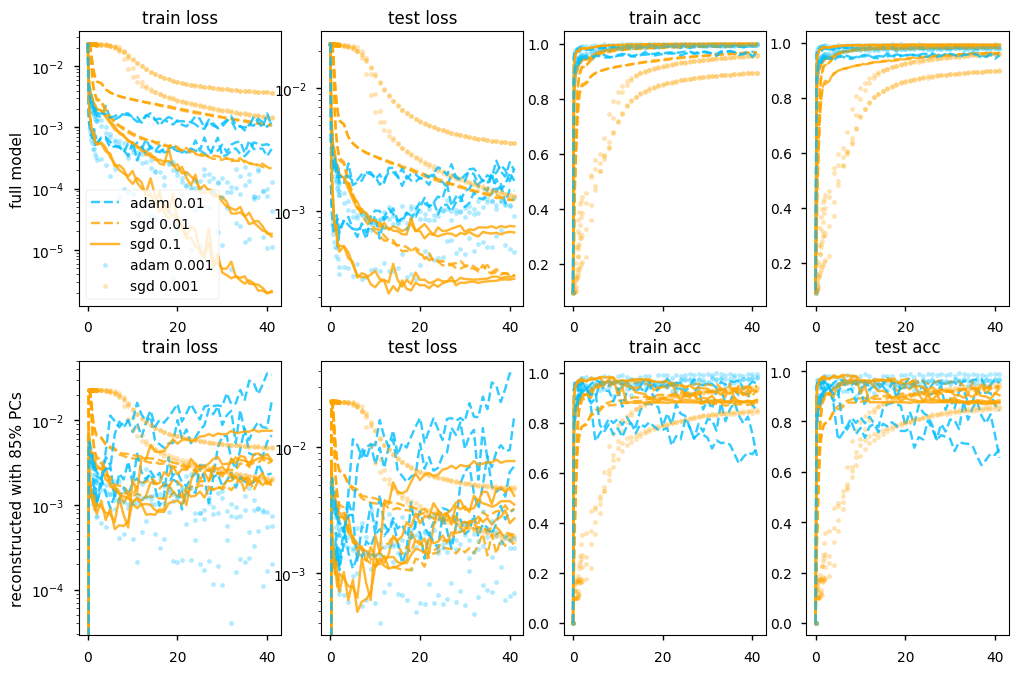

In [88]:
viz_losses.plot_losses(results, out_dir=save_dir)

In [ ]:
all_w = ['explained_var_dicts_pca', 'explained_var_dicts_rbf', 'explained_var_dicts_lap', 'explained_var_dicts_cosine']
acts = ['act_var_dicts_train_pca', 'act_var_dicts_test_pca', 'act_var_dicts_train_rbf', 'act_var_dicts_test_rbf']
viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=all_w, figname='ws')
# viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=acts, figname='acts')

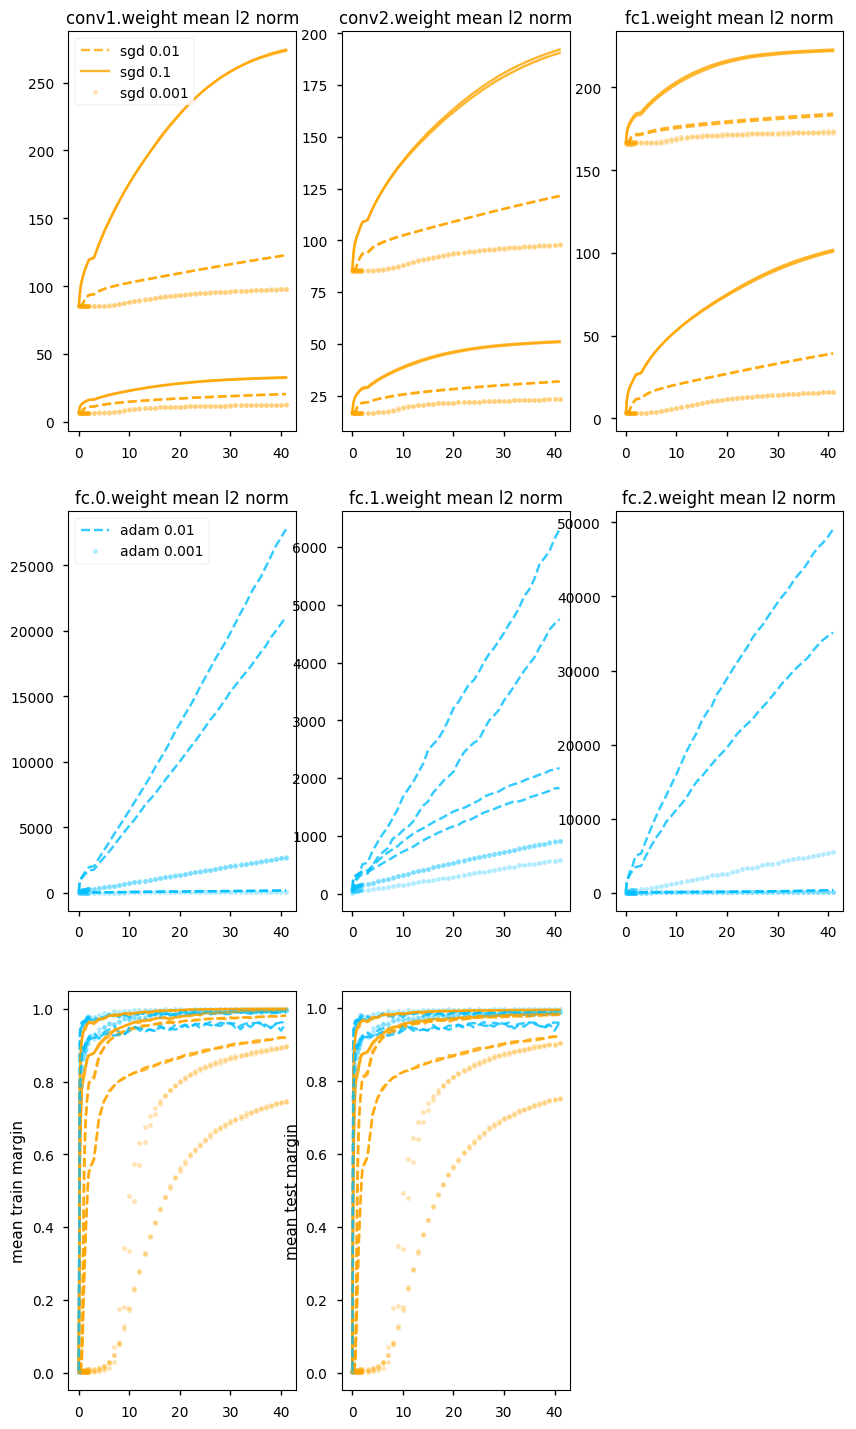

In [91]:
# note these norms were squared
# calculated via np.linalg.norm(weight_dict[lay_name])**2
viz_losses.plot_weight_norms_and_margin(results, out_dir='test')    

In [ ]:
all_w = ['explained_var_dicts_pca', 'explained_var_dicts_rbf', 'explained_var_dicts_lap', 'explained_var_dicts_cosine']
acts = ['act_var_dicts_train_pca', 'act_var_dicts_test_pca', 'act_var_dicts_train_rbf', 'act_var_dicts_test_rbf']
viz_losses.plot_dims_flexible(results, out_dir='test', xlim=None, dim_types=all_w, figname='ws')
# viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=all_w, figname='acts')    

# look at the weights

In [7]:
# depending on how much is saved, this may take a while
weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if fname.startswith('weights')]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()
# results.head()
# results_weights.dtypes

just plot them all (this takes ~2 mins)

ws.shape (20, 1, 5, 5)
d 5
ws.shape (20, 1, 5, 5)
d 5
ws.shape (20, 1, 5, 5)
d 5
err 'conv1.weight'
err 'conv1.weight'
ws.shape (20, 1, 5, 5)
d 5


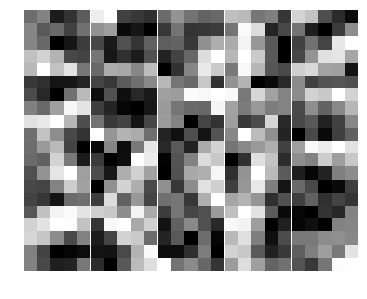

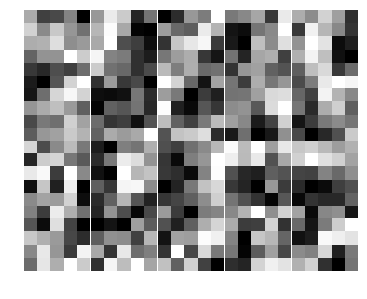

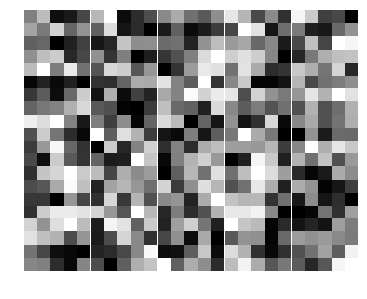

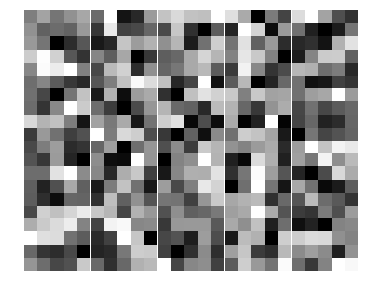

In [12]:
viz_weights.save_final_weights(results_weights, results, out_dir=save_dir)

In [ ]:
viz_weights.save_weight_evol(results_weights, out_dir=save_dir)

# other stuff not really used...

*compare dimensionality between sizes*

*visualize pcs*

In [ ]:
# pca
optimizer, lr = 'adam', 0.01

# get w
runs = results_weights[results_weights.lr==lr]
runs = runs[runs.optimizer==optimizer]
run = runs.iloc[0]
weight_dict = run.weights
w = weight_dict[max(weight_dict.keys())]['fc1.weight']

# look at pcs
pca = PCA(n_components=w.shape[1])
pca.fit(w)
cum = deepcopy(pca.explained_variance_ratio_)
for i in range(1, len(cum)):
    cum[i] += cum[i-1]
plt.plot(cum, 'o')
plt.ylabel('cumulative explained var')
plt.xlabel('num pcs')
plt.show()

print('first pcs..')
plot_weights(pca.components_[:200], run.dset)
plt.show()

*norm distributions*

In [ ]:
# pca
plt.figure(figsize=(9, 5))
R, C = 2, 3
for j, optimizer in enumerate(['sgd', 'adam']):
    for lr in [0.1, 0.01, 0.001]:
        if not (optimizer == 'adam' and lr == 0.1):
            # get ws
            runs = results_weights[results_weights.lr==lr]
            runs = runs[runs.optimizer==optimizer]
            run = runs.iloc[0]
            weight_dict_list = run.weights
            weight_dict = weight_dict_list[max(weight_dict_list.keys())]
            ws = [weight_dict['fc1.weight'], weight_dict['fc2.weight'], weight_dict['fc3.weight']]
            w_norms = [np.sum(np.abs(w)**2, axis=1)**(1./2) for w in ws]
    #         w_norms = [np.sum(np.abs(w)**1, axis=1)**(1./1) for w in ws]        

            plt.subplot(R, C, 1 + j * C)
            plt.hist(w_norms[0], label=str(lr))
            if j == 0:
                plt.title('lay1 norms')
            plt.ylabel(optimizer)

            plt.subplot(R, C, 2 + j * C)    
            plt.hist(w_norms[1], label=str(lr))
            if j == 0:
                plt.title('lay2 norms')    

            plt.subplot(R, C, 3 + j * C)    
            plt.hist(w_norms[2], label=str(lr))
            if j == 0:
                plt.title('lay3 norms')              
plt.legend()
plt.show()